In [4]:
import pandas as pd

In [5]:
dados = pd.read_csv('/content/df_limpo.csv')

In [6]:
dados.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Monthly,Total
0,0002-ORFBO,0.0,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30
1,0003-MKNFE,0.0,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40
2,0004-TLHLJ,1.0,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,1.0,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,1.0,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40


In [7]:
print(dados.columns)

Index(['customerID', 'Churn', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'tenure', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'Monthly', 'Total'],
      dtype='object')


In [8]:
dados.shape

(7032, 21)

In [9]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   Churn             7032 non-null   float64
 2   gender            7032 non-null   object 
 3   SeniorCitizen     7032 non-null   int64  
 4   Partner           7032 non-null   object 
 5   Dependents        7032 non-null   object 
 6   tenure            7032 non-null   int64  
 7   PhoneService      7032 non-null   object 
 8   MultipleLines     7032 non-null   object 
 9   InternetService   7032 non-null   object 
 10  OnlineSecurity    7032 non-null   object 
 11  OnlineBackup      7032 non-null   object 
 12  DeviceProtection  7032 non-null   object 
 13  TechSupport       7032 non-null   object 
 14  StreamingTV       7032 non-null   object 
 15  StreamingMovies   7032 non-null   object 
 16  Contract          7032 non-null   object 


In [10]:
dados.describe()

,Churn,SeniorCitizen,tenure,Monthly,Total
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.265785,0.162400,32.421786,64.798208,2283.300441
std,0.441782,0.368844,24.545260,30.085974,2266.771362
min,0.000000,0.000000,1.000000,18.250000,18.800000
25%,0.000000,0.000000,9.000000,35.587500,401.450000
50%,0.000000,0.000000,29.000000,70.350000,1397.475000
75%,1.000000,0.000000,55.000000,89.862500,3794.737500
max,1.000000,1.000000,72.000000,118.750000,8684.800000


In [11]:
# Pré processamento (remover colunas irrelevantes)
dados = dados.drop(columns=['customerID'])

In [12]:
#classificando váriaveis categóricas
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

colunas_categoricas = dados.select_dtypes(include='object').columns.tolist()

preprocessador = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop='first'), colunas_categoricas)
], remainder='passthrough')  # deixa as numéricas como estão

In [13]:
#divisão dos dados:
from sklearn.model_selection import train_test_split

X = dados.drop('Churn', axis=1)
y = dados['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [14]:
#criando pipeline com modelo "arvore de decisão"
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

pipeline = Pipeline([
    ('preprocessador', preprocessador),
    ('modelo', DecisionTreeClassifier(max_depth=5, random_state=42))
])


In [15]:
#treinar e avaliar o modelo
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.83      0.88      0.85      1033
         1.0       0.60      0.52      0.55       374

    accuracy                           0.78      1407
   macro avg       0.72      0.70      0.70      1407
weighted avg       0.77      0.78      0.77      1407



In [16]:
#verificar proporção dos clientes que evadiram:
y.value_counts(normalize=True) * 100

,proportion
Churn,
0.0,73.421502
1.0,26.578498


In [17]:
# vou balancear com SMOTE
from imblearn.over_sampling import SMOTE

# Aplicar o encoding definido no preprocessador
X_encoded = preprocessador.fit_transform(X)

# Criar SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_encoded, y)

# Verificar proporção após balanceamento
import numpy as np
np.bincount(y_res) / len(y_res) * 100


array([50., 50.])

In [18]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Garantir que X_res seja DataFrame para termos os nomes das colunas corretos
if not isinstance(X_res, pd.DataFrame):
    X_res = pd.DataFrame(X_res, columns=preprocessador.get_feature_names_out())

# Treinar Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_res, y_res)

# Criar DataFrame com importância
importancias = pd.DataFrame({
    'Variavel': X_res.columns,
    'Importancia': rf.feature_importances_
}).sort_values(by='Importancia', ascending=False)

# Mostrar top 15 variáveis
importancias.head(15)



,Variavel,Importancia
27,remainder__tenure,0.130388
29,remainder__Total,0.125979
28,remainder__Monthly,0.100646
24,cat__PaymentMethod_Electronic check,0.095270
21,cat__Contract_Two year,0.049116
15,cat__TechSupport_Yes,0.043371
6,cat__InternetService_Fiber optic,0.042566
20,cat__Contract_One year,0.041890
22,cat__PaperlessBilling_Yes,0.041856
9,cat__OnlineSecurity_Yes,0.038400


In [19]:
# treinar pipelines com preprocessador + SMOTE + modelo e comparar métricas
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Modelos a testar
modelos = {
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, n_jobs=1)  # n_jobs para LR depende da versão
}

# Se usar XGBoost e não tiver instalado, comente ou instale (pip install xgboost)
try:
    from xgboost import XGBClassifier
    modelos["XGBoost"] = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1)
except Exception:
    pass  # se não tiver xgboost, ok

resultados = []
pipelines_guardados = {}  # guardar pipelines para usar depois (matriz de confusão)

for nome, modelo in modelos.items():
    print(f"Treinando: {nome} ...")
    pipe = ImbPipeline(steps=[
        ('preprocessador', preprocessador),   # seu ColumnTransformer já definido
        ('smote', SMOTE(random_state=42)),
        ('modelo', modelo)
    ])

    # Fit no train (X_train, y_train) -- NOTE: use as amostras originais, NÃO X_res
    pipe.fit(X_train, y_train)

    # Prever no conjunto de teste (X_test sem transformação: pipeline aplica preprocessador internamente)
    y_pred = pipe.predict(X_test)

    # Calcular métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    resultados.append({
        "Modelo": nome,
        "Acurácia": acc,
        "Precisão": prec,
        "Recall": rec,
        "F1-Score": f1
    })

    pipelines_guardados[nome] = pipe  # salvar pipeline para uso posterior

# Mostrar resultados
df_resultados = pd.DataFrame(resultados).sort_values(by="F1-Score", ascending=False).reset_index(drop=True)
df_resultados


Treinando: Random Forest ...
Treinando: Logistic Regression ...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Treinando: XGBoost ...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:34:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Modelo,Acurácia,Precisão,Recall,F1-Score
0,Logistic Regression,0.748401,0.517483,0.791444,0.625793
1,XGBoost,0.778962,0.596923,0.518717,0.555079
2,Random Forest,0.784648,0.618729,0.494652,0.549777


Melhor modelo: Logistic Regression


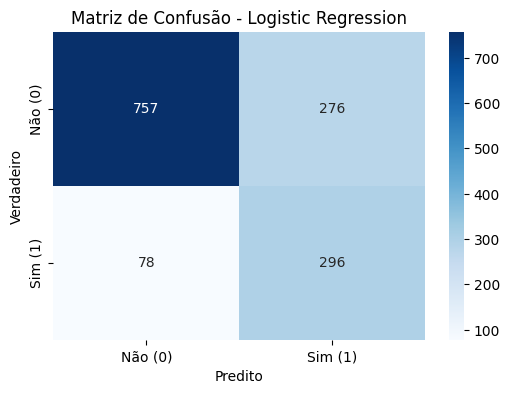


Classification Report:

              precision    recall  f1-score   support

         0.0     0.9066    0.7328    0.8105      1033
         1.0     0.5175    0.7914    0.6258       374

    accuracy                         0.7484      1407
   macro avg     0.7120    0.7621    0.7181      1407
weighted avg     0.8032    0.7484    0.7614      1407



In [20]:
# escolher o melhor modelo (por F1) e plotar matriz de confusão + classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Selecionar melhor modelo pelo F1 (primeira linha do df_resultados)
melhor_nome = df_resultados.loc[0, 'Modelo']
melhor_pipeline = pipelines_guardados[melhor_nome]

print(f"Melhor modelo: {melhor_nome}")

# Prever no teste
y_pred_melhor = melhor_pipeline.predict(X_test)

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred_melhor)
labels = ['Não (0)', 'Sim (1)']

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title(f'Matriz de Confusão - {melhor_nome}')
plt.show()

# Relatório detalhado
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_melhor, digits=4))


In [21]:
# imports e cv rápido
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CV que uso no RandomizedSearch
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)


In [22]:
# tuning Random Forest
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

pipe_rf = ImbPipeline(steps=[
    ('preprocessador', preprocessador),
    ('smote', SMOTE(random_state=42)),
    ('modelo', RandomForestClassifier(random_state=42, n_jobs=-1))
])

param_dist_rf = {
    'modelo__n_estimators': [100, 200, 300],
    'modelo__max_depth': [6, 10, 15, None],
    'modelo__min_samples_split': [2, 5, 10],
    'modelo__min_samples_leaf': [1, 2, 4],
    'modelo__max_features': ['sqrt', 'log2', None]
}

rs_rf = RandomizedSearchCV(
    estimator=pipe_rf,
    param_distributions=param_dist_rf,
    n_iter=10,            # ajustar para mais/menos tentativas
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=2
)

rs_rf.fit(X_train, y_train)
print("Melhores parâmetros RF:", rs_rf.best_params_)
print("Melhor score (cv f1):", rs_rf.best_score_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Melhores parâmetros RF: {'modelo__n_estimators': 100, 'modelo__min_samples_split': 2, 'modelo__min_samples_leaf': 2, 'modelo__max_features': 'sqrt', 'modelo__max_depth': 6}
Melhor score (cv f1): 0.6292679385897784


Classification report - RF:
              precision    recall  f1-score   support

         0.0       0.88      0.81      0.84      1033
         1.0       0.57      0.69      0.62       374

    accuracy                           0.78      1407
   macro avg       0.72      0.75      0.73      1407
weighted avg       0.80      0.78      0.79      1407



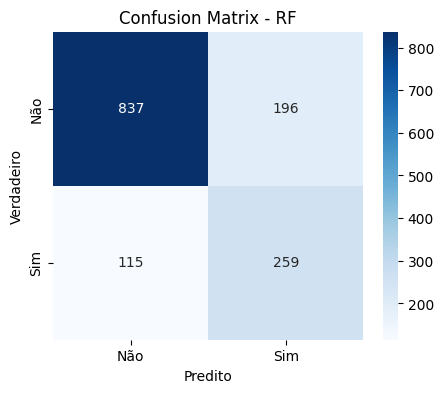

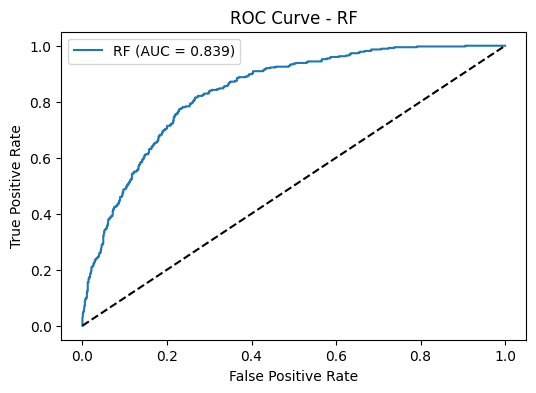

In [23]:
# avaliação do melhor RandomForest no teste
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

best_rf = rs_rf.best_estimator_

y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:,1]  # probabilidades da classe 1

print("Classification report - RF:")
print(classification_report(y_test, y_pred_rf))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Não','Sim'], yticklabels=['Não','Sim'])
plt.title('Confusion Matrix - RF')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

# ROC AUC
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'RF (AUC = {roc_auc_rf:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RF')
plt.legend()
plt.show()


In [24]:
!pip install xgboost

In [25]:
# tuning XGBoost
try:
    from xgboost import XGBClassifier
    pipe_xgb = ImbPipeline(steps=[
        ('preprocessador', preprocessador),
        ('smote', SMOTE(random_state=42)),
        ('modelo', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1))
    ])

    param_dist_xgb = {
        'modelo__n_estimators': [100, 200, 300],
        'modelo__max_depth': [3, 6, 10],
        'modelo__learning_rate': [0.01, 0.05, 0.1],
        'modelo__subsample': [0.6, 0.8, 1.0],
        'modelo__colsample_bytree': [0.6, 0.8, 1.0]
    }

    rs_xgb = RandomizedSearchCV(
        estimator=pipe_xgb,
        param_distributions=param_dist_xgb,
        n_iter=10,
        scoring='f1',
        cv=cv,
        n_jobs=-1,
        random_state=42,
        verbose=2
    )

    rs_xgb.fit(X_train, y_train)
    print("Melhores parâmetros XGB:", rs_xgb.best_params_)
    print("Melhor score (cv f1):", rs_xgb.best_score_)

except Exception as e:
    print("XGBoost não disponível ou erro:", e)
    rs_xgb = None


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:36:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Melhores parâmetros XGB: {'modelo__subsample': 0.6, 'modelo__n_estimators': 300, 'modelo__max_depth': 3, 'modelo__learning_rate': 0.01, 'modelo__colsample_bytree': 0.6}
Melhor score (cv f1): 0.6350676259835534


Classification report - XGBoost:
              precision    recall  f1-score   support

         0.0       0.88      0.82      0.85      1033
         1.0       0.58      0.69      0.63       374

    accuracy                           0.78      1407
   macro avg       0.73      0.75      0.74      1407
weighted avg       0.80      0.78      0.79      1407



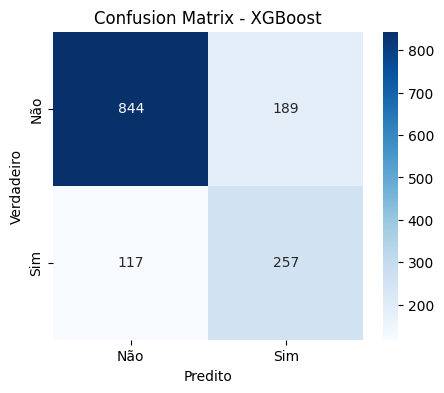

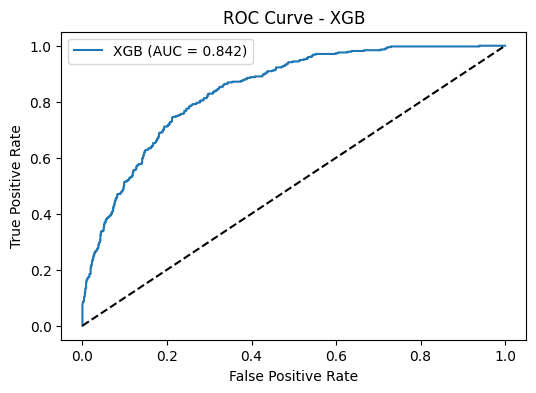

In [26]:
# avaliação do melhor XGB
if rs_xgb is not None:
    best_xgb = rs_xgb.best_estimator_
    y_pred_xgb = best_xgb.predict(X_test)
    y_proba_xgb = best_xgb.predict_proba(X_test)[:,1]

    print("Classification report - XGBoost:")
    print(classification_report(y_test, y_pred_xgb))

    cm = confusion_matrix(y_test, y_pred_xgb)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Não','Sim'], yticklabels=['Não','Sim'])
    plt.title('Confusion Matrix - XGBoost')
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.show()

    roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb)
    fpr, tpr, _ = roc_curve(y_test, y_proba_xgb)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f'XGB (AUC = {roc_auc_xgb:.3f})')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - XGB')
    plt.legend()
    plt.show()
else:
    print("XGBoost não foi rodado.")


In [27]:
# Comparativo simples
resultados = []

# RF
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:,1]
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
resultados.append({
    'Modelo': 'Random Forest (tuned)',
    'Acuracia': accuracy_score(y_test, y_pred),
    'Precisao': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1': f1_score(y_test, y_pred),
    'ROC_AUC': roc_auc_score(y_test, y_proba)
})

# XGB
if rs_xgb is not None:
    y_pred = best_xgb.predict(X_test)
    y_proba = best_xgb.predict_proba(X_test)[:,1]
    resultados.append({
        'Modelo': 'XGBoost (tuned)',
        'Acuracia': accuracy_score(y_test, y_pred),
        'Precisao': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC_AUC': roc_auc_score(y_test, y_proba)
    })

pd.DataFrame(resultados).sort_values(by='F1', ascending=False).reset_index(drop=True)


,Modelo,Acuracia,Precisao,Recall,F1,ROC_AUC
0,XGBoost (tuned),0.782516,0.576233,0.687166,0.626829,0.842212
1,Random Forest (tuned),0.778962,0.569231,0.692513,0.624849,0.838621


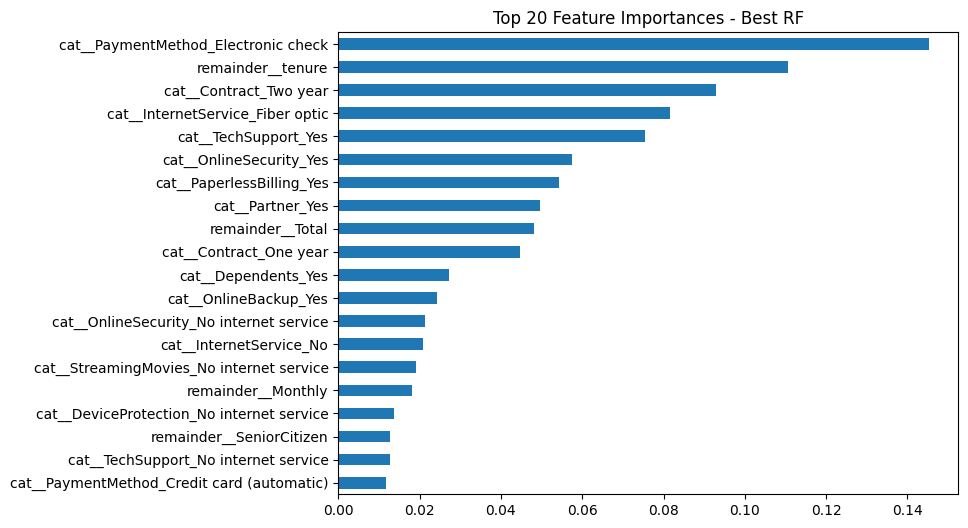

In [28]:
# feature importances do melhor modelo (assumindo RF)
# Obter o modelo dentro do pipeline
modelo_interno = best_rf.named_steps['modelo']

# Recupere nomes das features a partir do preprocessador (scikit-learn >=1.0)
try:
    feature_names = best_rf.named_steps['preprocessador'].get_feature_names_out()
except Exception:
    # alternativa segura: usar ColumnTransformer get_feature_names_out se disponível
    feature_names = preprocessador.get_feature_names_out()

importancias = pd.Series(modelo_interno.feature_importances_, index=feature_names)
importancias_sorted = importancias.sort_values(ascending=False)
importancias_sorted.head(20).plot(kind='barh', figsize=(8,6))
plt.gca().invert_yaxis()
plt.title('Top 20 Feature Importances - Best RF')
plt.show()


In [29]:
# salvar melhor pipeline (escolher entre best_rf e best_xgb pelo F1)
# Suponha que best_rf seja o escolhido; se preferir best_xgb, troque.
joblib.dump(best_rf, "/content/best_pipeline_rf.joblib")
print("Salvo em /content/best_pipeline_rf.joblib")
# Para carregar depois:
# loaded = joblib.load("/content/best_pipeline_rf.joblib")
# loaded.predict(X_test[:5])


Salvo em /content/best_pipeline_rf.joblib


In [30]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

# Tenho criar a pasta 'graficos'
if not os.path.exists("graficos"):
    os.makedirs("graficos")

# Extrair o modelo do pipeline
modelo_final = best_rf.named_steps['modelo']

# Obter os nomes das features
try:
    feature_names = best_rf.named_steps['preprocessador'].get_feature_names_out()
except Exception:
    feature_names = preprocessador.get_feature_names_out()

# Importância das variáveis
importancias = pd.Series(modelo_final.feature_importances_, index=feature_names)
importancias_sorted = importancias.sort_values(ascending=True)  # Para gráfico horizontal

plt.figure(figsize=(8,6))
importancias_sorted.tail(20).plot(kind='barh', color='skyblue')  # Top 20
plt.title("Top 20 Importância das Variáveis")
plt.xlabel("Peso")
plt.tight_layout()
plt.savefig("graficos/importancia_variaveis.png", dpi=300)
plt.close()

# Matriz de confusão
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, cmap='Blues')
plt.title("Matriz de Confusão")
plt.savefig("graficos/matriz_confusao.png", dpi=300)
plt.close()

# Curva ROC
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Falso Positivo")
plt.ylabel("Verdadeiro Positivo")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.savefig("graficos/curva_roc.png", dpi=300)
plt.close()

print("✅ Gráficos salvos com sucesso na pasta 'graficos/'")

✅ Gráficos salvos com sucesso na pasta 'graficos/'


In [31]:
# transformar X (todas as features) em formato numérico e guardar nomes
# Separar X (sem target)
X = dados.drop(columns='Churn')

# Aplicar o preprocessador (fit_transform pois é EDA)
X_encoded_array = preprocessador.fit_transform(X)

# Obter nomes das colunas geradas pelo ColumnTransformer / OneHotEncoder
try:
    feature_names = preprocessador.get_feature_names_out()
except Exception:
    # fallback para versões antigas
    cat_names = preprocessador.named_transformers_['cat'].get_feature_names_out(colunas_categoricas)
    num_names = dados.select_dtypes(exclude='object').columns.tolist()
    feature_names = np.concatenate([cat_names, num_names])

# Criar DataFrame com os nomes
X_enc_df = pd.DataFrame(X_encoded_array, columns=feature_names)

# juntar com o target para facilitar análises
df_enc = pd.concat([X_enc_df.reset_index(drop=True), dados['Churn'].reset_index(drop=True)], axis=1)

print("Shape X_enc_df:", X_enc_df.shape)
df_enc.head()

Shape X_enc_df: (7032, 30)


,cat__gender_Male,cat__Partner_Yes,cat__Dependents_Yes,cat__PhoneService_Yes,cat__MultipleLines_No phone service,cat__MultipleLines_Yes,cat__InternetService_Fiber optic,cat__InternetService_No,cat__OnlineSecurity_No internet service,cat__OnlineSecurity_Yes,...,cat__Contract_Two year,cat__PaperlessBilling_Yes,cat__PaymentMethod_Credit card (automatic),cat__PaymentMethod_Electronic check,cat__PaymentMethod_Mailed check,remainder__SeniorCitizen,remainder__tenure,remainder__Monthly,remainder__Total,Churn
0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,9.0,65.6,593.30,0.0
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,9.0,59.9,542.40,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,4.0,73.9,280.85,1.0
3,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,13.0,98.0,1237.85,1.0
4,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,3.0,83.9,267.40,1.0


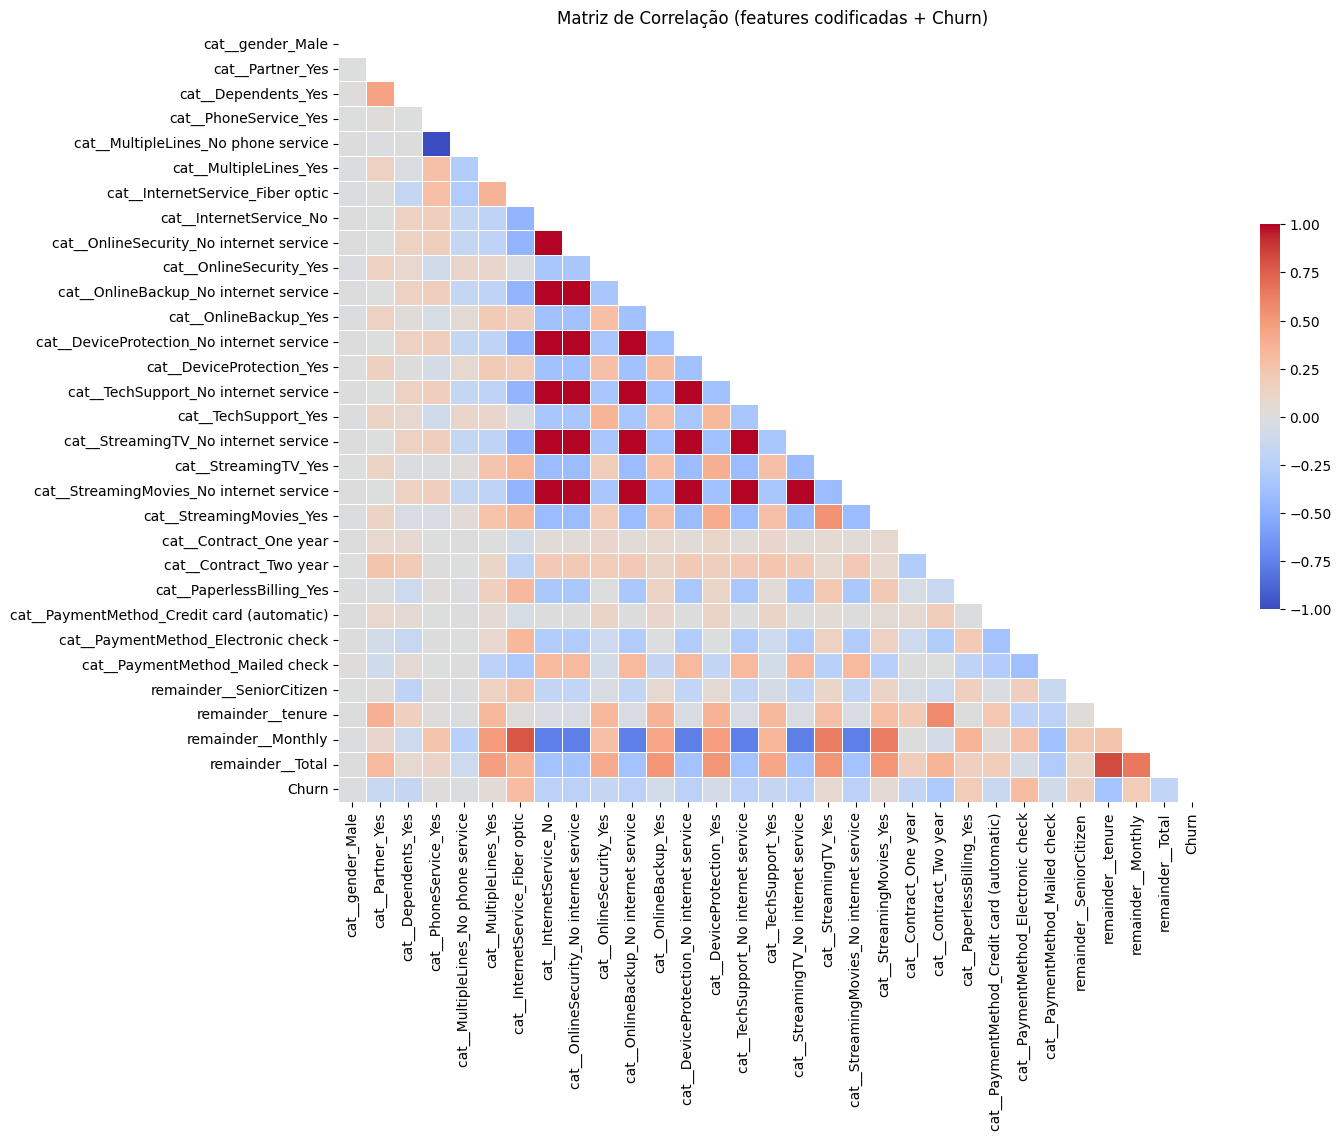

In [32]:
# matriz de correlação e heatmap
import matplotlib.pyplot as plt
import seaborn as sns

corr = df_enc.corr()

plt.figure(figsize=(14,10))
# máscara para top-right
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Matriz de Correlação (features codificadas + Churn)")
plt.show()


In [33]:
# ranking por correlação com Churn
corr_with_target = corr['Churn'].drop('Churn').sort_values(ascending=False)
pd.DataFrame({
    'feature': corr_with_target.index,
    'corr_with_churn': corr_with_target.values
}).head(30)


,feature,corr_with_churn
0,cat__InternetService_Fiber optic,0.307463
1,cat__PaymentMethod_Electronic check,0.301455
2,remainder__Monthly,0.192858
3,cat__PaperlessBilling_Yes,0.191454
4,remainder__SeniorCitizen,0.150541
5,cat__StreamingTV_Yes,0.063254
6,cat__StreamingMovies_Yes,0.060860
7,cat__MultipleLines_Yes,0.040033
8,cat__PhoneService_Yes,0.011691
9,cat__gender_Male,-0.008545


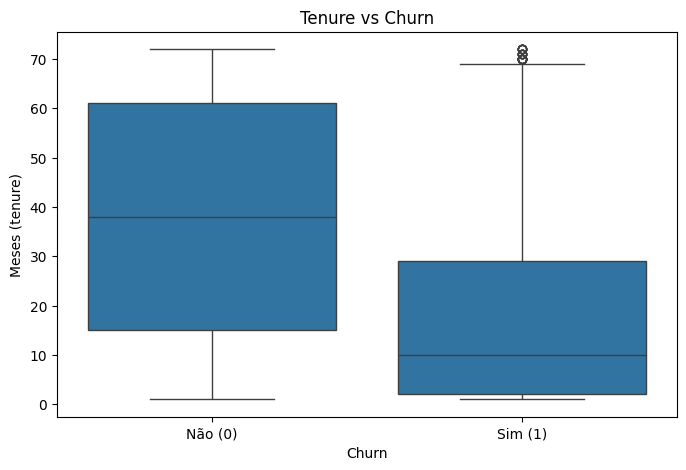

In [34]:
# boxplot tenure x churn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(x='Churn', y='tenure', data=dados)
plt.xticks([0,1], ['Não (0)', 'Sim (1)'])
plt.title('Tenure vs Churn')
plt.ylabel('Meses (tenure)')
plt.xlabel('Churn')
plt.show()


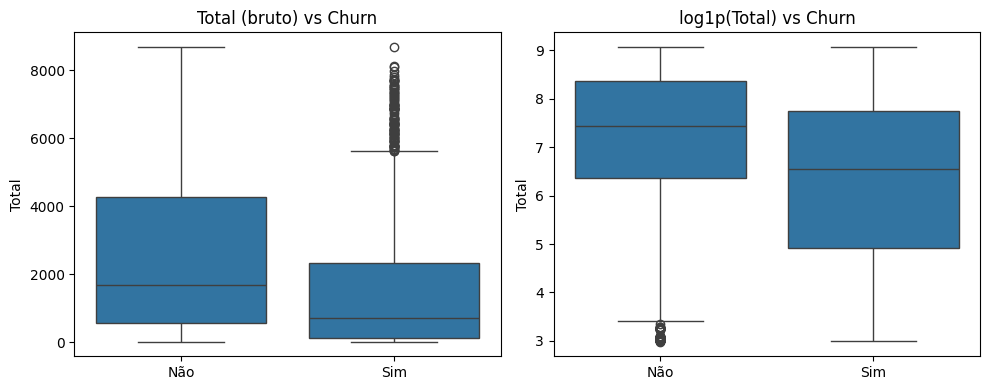

In [35]:
# boxplot Total x Churn (raw e log)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.boxplot(x='Churn', y='Total', data=dados)
plt.title('Total (bruto) vs Churn')
plt.xlabel('')
plt.xticks([0,1], ['Não','Sim'])

plt.subplot(1,2,2)
sns.boxplot(x='Churn', y=np.log1p(dados['Total']), data=dados)
plt.title('log1p(Total) vs Churn')
plt.xlabel('')
plt.xticks([0,1], ['Não','Sim'])

plt.tight_layout()
plt.show()


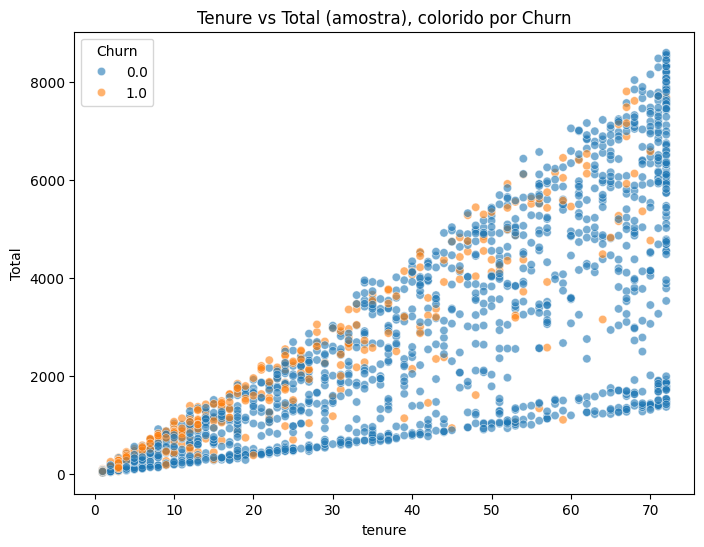

In [36]:
# scatter tenure x Total com cor por Churn (amostra)
import seaborn as sns
import matplotlib.pyplot as plt

sample = dados.sample(n=2000, random_state=42) if len(dados) > 2000 else dados
plt.figure(figsize=(8,6))
sns.scatterplot(data=sample, x='tenure', y='Total', hue='Churn', alpha=0.6)
plt.title('Tenure vs Total (amostra), colorido por Churn')
plt.show()


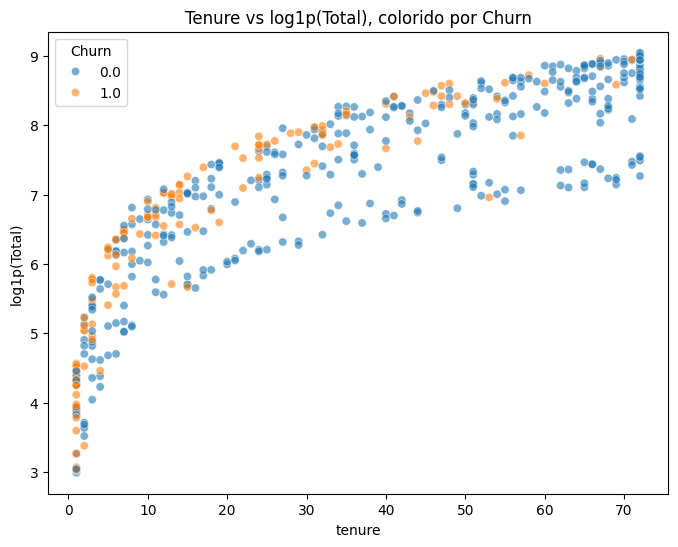

In [37]:
sample = dados.sample(500, random_state=42)

plt.figure(figsize=(8,6))
sns.scatterplot(data=sample, x='tenure', y=np.log1p(sample['Total']), hue='Churn', alpha=0.6)
plt.ylabel('log1p(Total)')
plt.title('Tenure vs log1p(Total), colorido por Churn')
plt.show()


In [38]:
# seleção por mutual information
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# X_enc_df foi criado na célula 1 (features numéricas / dummies)
X_feat = X_enc_df.values
y_target = dados['Churn'].values

# Escolher k (ex.: top 20)
k = 20
selector = SelectKBest(mutual_info_classif, k=k)
selector.fit(X_feat, y_target)

scores = selector.scores_
feat_scores = pd.DataFrame({
    'feature': X_enc_df.columns,
    'mi_score': scores
}).sort_values(by='mi_score', ascending=False)

feat_scores.head(30)


,feature,mi_score
27,remainder__tenure,0.077223
21,cat__Contract_Two year,0.058276
28,remainder__Monthly,0.047714
24,cat__PaymentMethod_Electronic check,0.046506
6,cat__InternetService_Fiber optic,0.044321
29,remainder__Total,0.043213
16,cat__StreamingTV_No internet service,0.037053
8,cat__OnlineSecurity_No internet service,0.036599
14,cat__TechSupport_No internet service,0.034045
18,cat__StreamingMovies_No internet service,0.032821


In [39]:
# (opcional): calcular VIF (para features numéricas)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# usar X_enc_df (ou escolha um subconjunto)
X_vif = X_enc_df.copy()

# calcular VIF (pode demorar se muitas features)
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

vif_data.sort_values(by='VIF', ascending=False).head(20)


/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
8,cat__OnlineSecurity_No internet service,inf
7,cat__InternetService_No,inf
10,cat__OnlineBackup_No internet service,inf
12,cat__DeviceProtection_No internet service,inf
16,cat__StreamingTV_No internet service,inf
14,cat__TechSupport_No internet service,inf
18,cat__StreamingMovies_No internet service,inf
3,cat__PhoneService_Yes,1773.528816
28,remainder__Monthly,866.089640
6,cat__InternetService_Fiber optic,148.500814


In [40]:
# combinar rankings para sugerir features
top_corr = corr_with_target.abs().sort_values(ascending=False).head(25).index.tolist()
top_mi = feat_scores['feature'].head(25).tolist()

# Combinar (preservando ordem) e pegar únicos
from collections import OrderedDict
combined = list(OrderedDict.fromkeys(top_corr + top_mi))

# selecionar os 20 primeiros como sugestão
suggested_features = combined[:20]
suggested_features


['remainder__tenure',
 'cat__InternetService_Fiber optic',
 'cat__Contract_Two year',
 'cat__PaymentMethod_Electronic check',
 'cat__StreamingMovies_No internet service',
 'cat__OnlineSecurity_No internet service',
 'cat__StreamingTV_No internet service',
 'cat__InternetService_No',
 'cat__DeviceProtection_No internet service',
 'cat__OnlineBackup_No internet service',
 'cat__TechSupport_No internet service',
 'remainder__Total',
 'remainder__Monthly',
 'cat__PaperlessBilling_Yes',
 'cat__Contract_One year',
 'cat__OnlineSecurity_Yes',
 'cat__TechSupport_Yes',
 'cat__Dependents_Yes',
 'remainder__SeniorCitizen',
 'cat__Partner_Yes']

In [41]:
# inspecionar colunas
print("Colunas originais em X_train:\n", X_train.columns.tolist())

# Se preprocessador foi fitado antes (ex: usou preprocessador.fit_transform), mostre nomes gerados:
try:
    feature_names = preprocessador.get_feature_names_out()
    print("\nAlguns feature_names gerados pelo preprocessador (ex.: 50 primeiros):\n", feature_names[:50])
except Exception as e:
    print("\nO preprocessador ainda não foi fitado ou get_feature_names_out não está disponível. Erro:", e)


Colunas originais em X_train:
 ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Monthly', 'Total']

Alguns feature_names gerados pelo preprocessador (ex.: 50 primeiros):
 ['cat__gender_Male' 'cat__Partner_Yes' 'cat__Dependents_Yes'
 'cat__PhoneService_Yes' 'cat__MultipleLines_No phone service'
 'cat__MultipleLines_Yes' 'cat__InternetService_Fiber optic'
 'cat__InternetService_No' 'cat__OnlineSecurity_No internet service'
 'cat__OnlineSecurity_Yes' 'cat__OnlineBackup_No internet service'
 'cat__OnlineBackup_Yes' 'cat__DeviceProtection_No internet service'
 'cat__DeviceProtection_Yes' 'cat__TechSupport_No internet service'
 'cat__TechSupport_Yes' 'cat__StreamingTV_No internet service'
 'cat__StreamingTV_Yes' 'cat__StreamingMovies_No internet service'
 'cat__StreamingMovies

In [42]:
whos


Variable                    Type                      Data/Info
---------------------------------------------------------------
ColumnTransformer           ABCMeta                   <class 'sklearn.compose._<...>ormer.ColumnTransformer'>
ConfusionMatrixDisplay      type                      <class 'sklearn.metrics._<...>.ConfusionMatrixDisplay'>
DecisionTreeClassifier      ABCMeta                   <class 'sklearn.tree._cla<...>.DecisionTreeClassifier'>
ImbPipeline                 ABCMeta                   <class 'imblearn.pipeline.Pipeline'>
LogisticRegression          type                      <class 'sklearn.linear_mo<...>stic.LogisticRegression'>
OneHotEncoder               type                      <class 'sklearn.preproces<...>_encoders.OneHotEncoder'>
OrderedDict                 type                      <class 'collections.OrderedDict'>
Pipeline                    ABCMeta                   <class 'sklearn.pipeline.Pipeline'>
RandomForestClassifier      ABCMeta                  

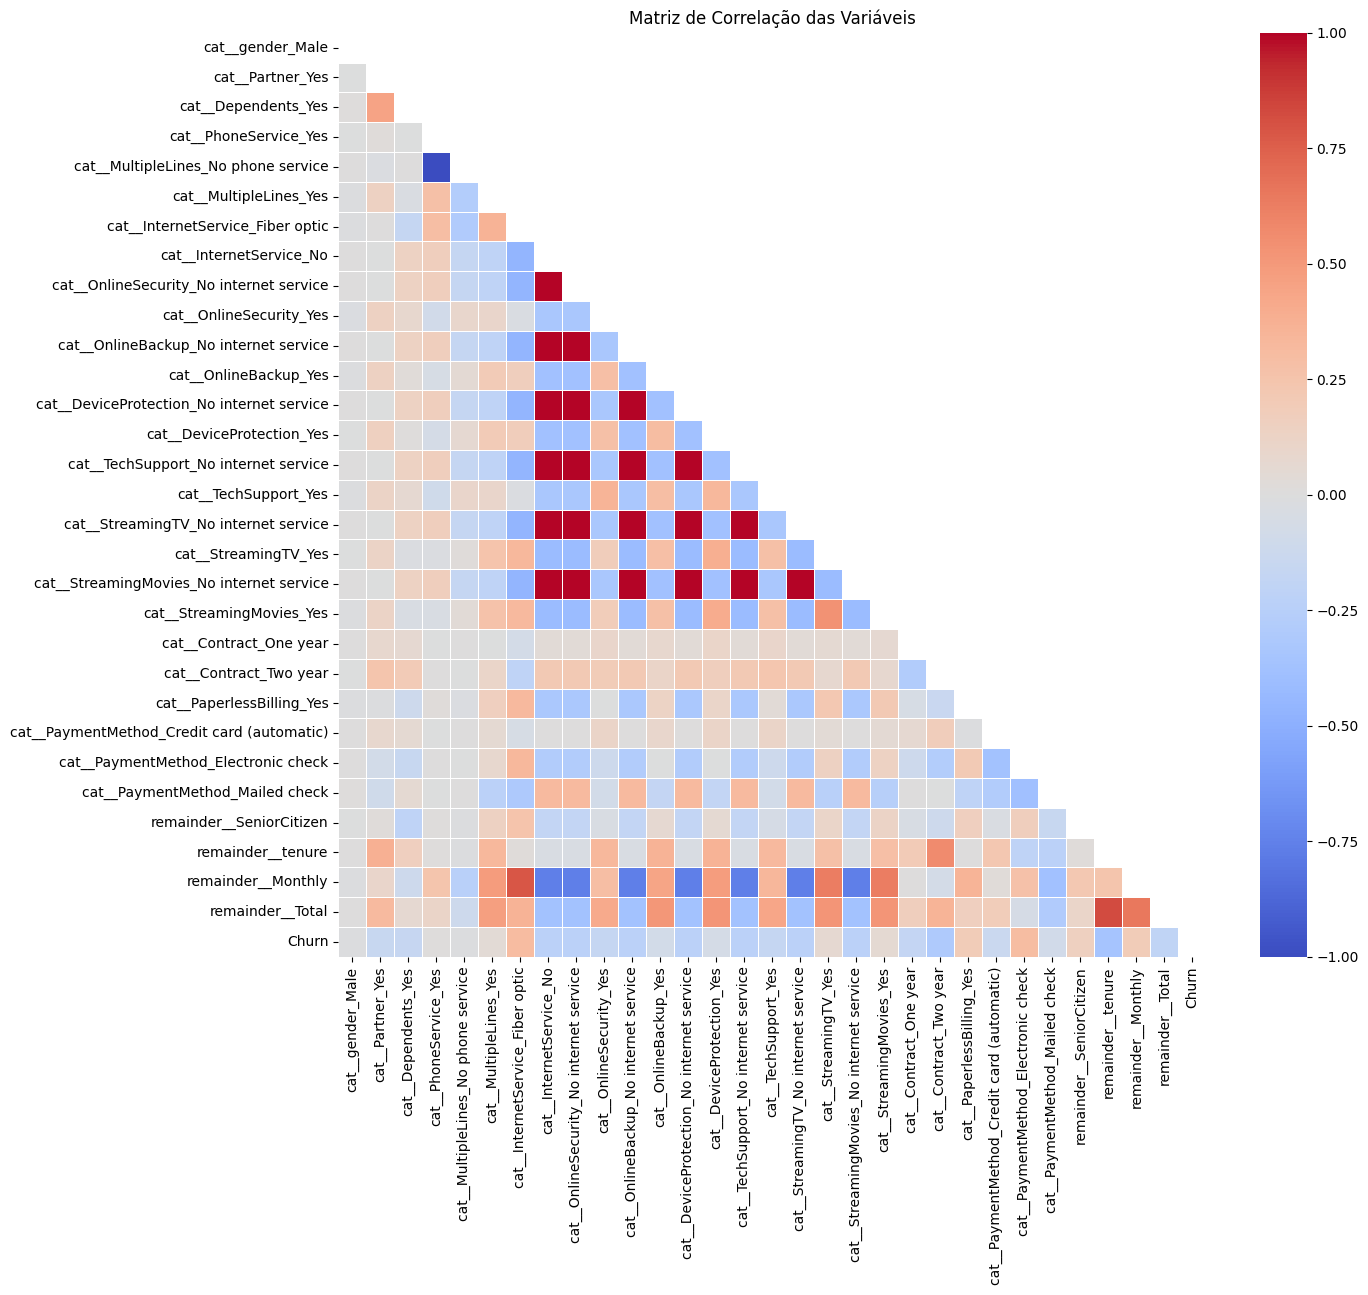

In [43]:
plt.figure(figsize=(14, 12))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0, mask=mask, linewidths=.5)
plt.title('Matriz de Correlação das Variáveis')
plt.show()


/tmp/ipython-input-2296804816.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_target.values, y=corr_target.index, palette='viridis')


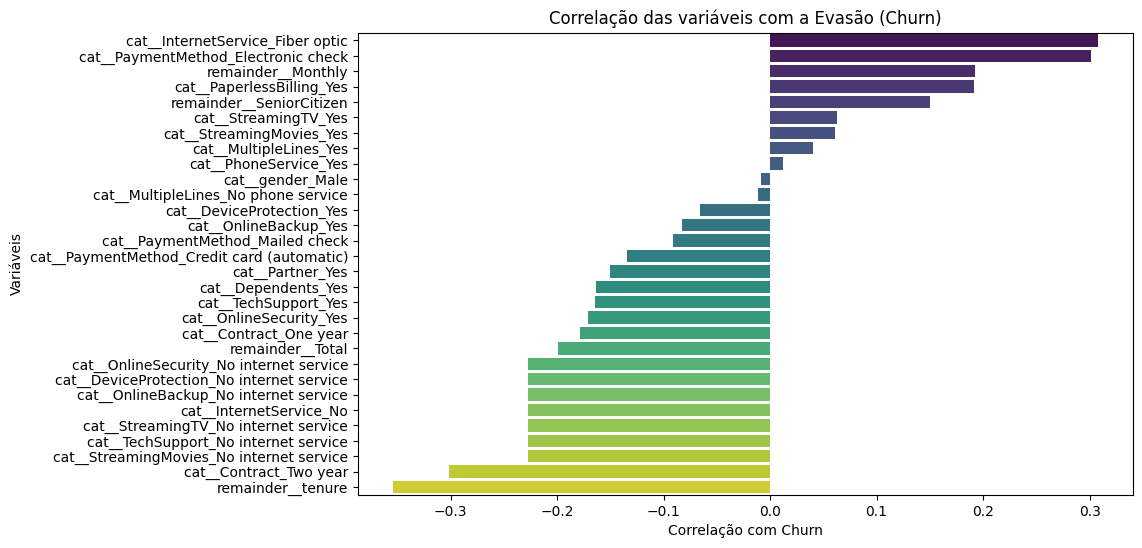

In [44]:
# Correlação com a variável alvo
corr_target = corr['Churn'].drop('Churn').sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=corr_target.values, y=corr_target.index, palette='viridis')
plt.title('Correlação das variáveis com a Evasão (Churn)')
plt.xlabel('Correlação com Churn')
plt.ylabel('Variáveis')
plt.show()


tempo de contrato x evasão


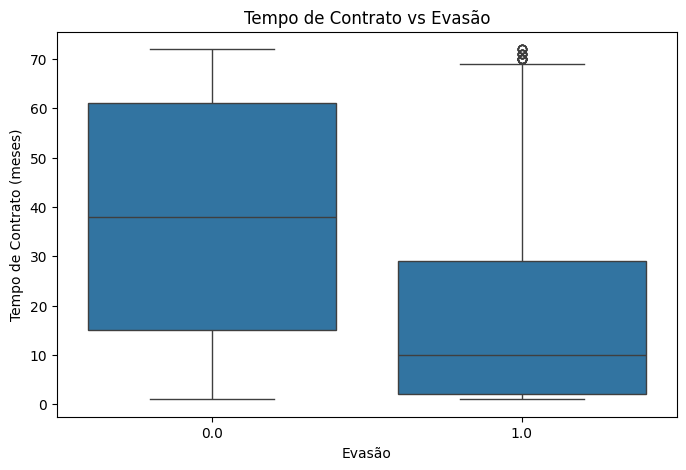

In [45]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=dados, x='Churn', y='tenure')  # ou 'TotalCharges' se tiver com outro nome
plt.title('Tempo de Contrato vs Evasão')
plt.xlabel('Evasão')
plt.ylabel('Tempo de Contrato (meses)')
plt.show()


In [46]:
dados.columns

Index(['Churn', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'Monthly', 'Total'],
      dtype='object')

/tmp/ipython-input-2324460059.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_with_churn.values, y=corr_with_churn.index, palette='viridis')


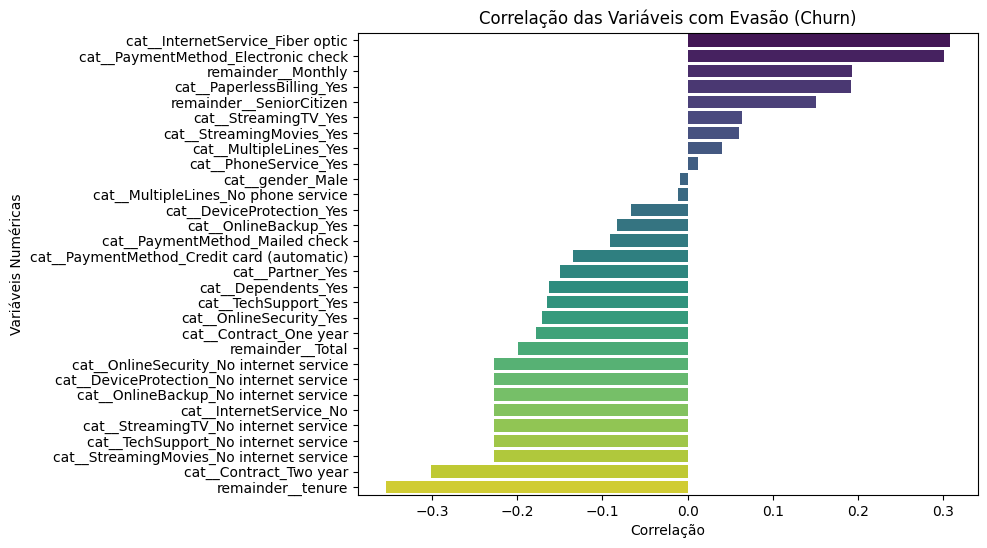

In [47]:
# Converter Churn para numérico, se necessário
dados['Churn'] = dados['Churn'].map({'No': 0, 'Yes': 1}) if dados['Churn'].dtype == 'object' else dados['Churn']

# Correlação com Churn
corr_with_churn = corr['Churn'].drop('Churn').sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=corr_with_churn.values, y=corr_with_churn.index, palette='viridis')
plt.title('Correlação das Variáveis com Evasão (Churn)')
plt.xlabel('Correlação')
plt.ylabel('Variáveis Numéricas')
plt.show()


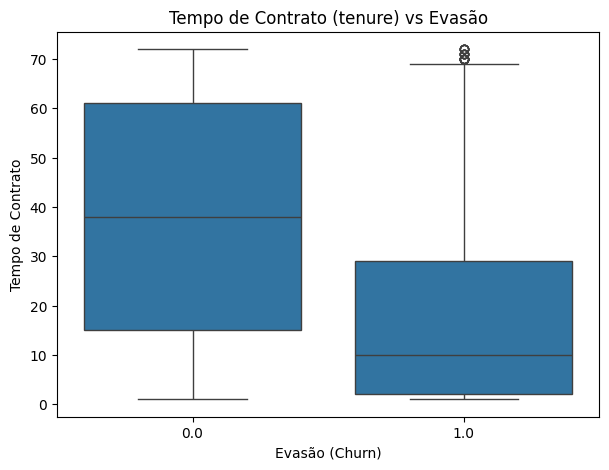

In [48]:
#tenure x churn
plt.figure(figsize=(7, 5))
sns.boxplot(data=dados, x='Churn', y='tenure')
plt.title('Tempo de Contrato (tenure) vs Evasão')
plt.xlabel('Evasão (Churn)')
plt.ylabel('Tempo de Contrato')
plt.show()


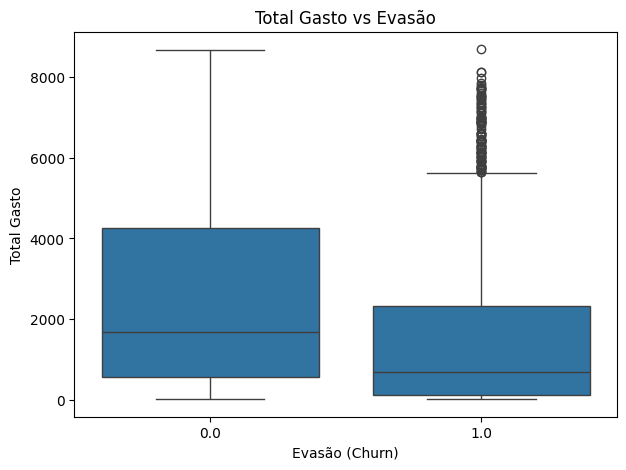

In [49]:
#total x churn
plt.figure(figsize=(7, 5))
sns.boxplot(data=dados, x='Churn', y='Total')
plt.title('Total Gasto vs Evasão')
plt.xlabel('Evasão (Churn)')
plt.ylabel('Total Gasto')
plt.show()


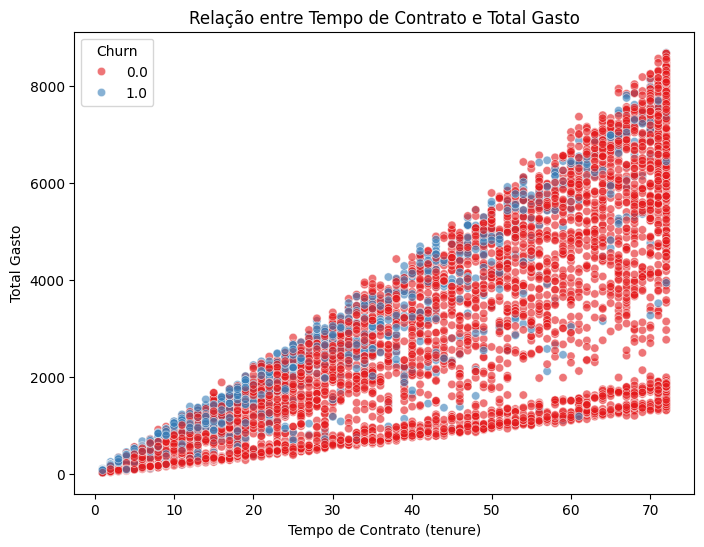

In [50]:
#Dispersão entre tenure e Total, colorido por Churn
plt.figure(figsize=(8, 6))
sns.scatterplot(data=dados, x='tenure', y='Total', hue='Churn', palette='Set1', alpha=0.6)
plt.title('Relação entre Tempo de Contrato e Total Gasto')
plt.xlabel('Tempo de Contrato (tenure)')
plt.ylabel('Total Gasto')
plt.legend(title='Churn')
plt.show()


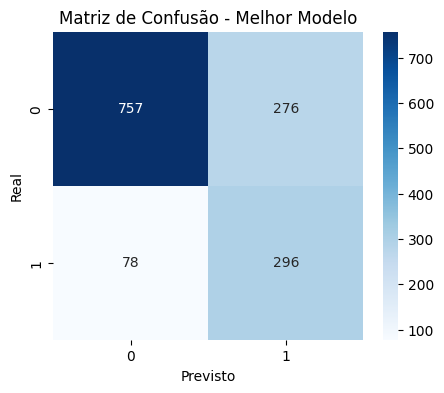

Relatório de Classificação:

              precision    recall  f1-score   support

         0.0       0.91      0.73      0.81      1033
         1.0       0.52      0.79      0.63       374

    accuracy                           0.75      1407
   macro avg       0.71      0.76      0.72      1407
weighted avg       0.80      0.75      0.76      1407



In [51]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- MATRIZ DE CONFUSÃO E RELATÓRIO ---
# Supondo que você tenha as previsões do melhor modelo:
y_pred = melhor_pipeline.predict(X_test)

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Melhor Modelo")
plt.show()

# Classification report
print("Relatório de Classificação:\n")
print(classification_report(y_test, y_pred))

In [51]:
# Selecionar melhor modelo pelo F1
melhor_nome = df_resultados.loc[df_resultados['F1'].idxmax(), 'Modelo']
melhor_pipeline = pipelines_guardados[melhor_nome]

print(f"Melhor modelo escolhido pelo F1: {melhor_nome}")

# Prever no conjunto de teste
y_pred_melhor = melhor_pipeline.predict(X_test)

# --- MATRIZ DE CONFUSÃO ---
cm = confusion_matrix(y_test, y_pred_melhor)
labels = ['Não (0)', 'Sim (1)']

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title(f'Matriz de Confusão - {melhor_nome}')
plt.show()

# --- RELATÓRIO DE CLASSIFICAÇÃO ---
print("\nRelatório de Classificação:\n")
print(classification_report(y_test, y_pred_melhor, digits=4))


In [54]:
print(df_resultados.columns)

Index(['Modelo', 'Acurácia', 'Precisão', 'Recall', 'F1-Score'], dtype='object')


🔍 Melhor modelo escolhido pelo F1-score: Logistic Regression


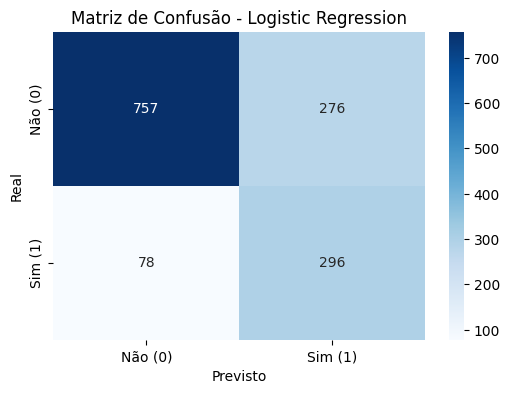


📊 Classification Report:

              precision    recall  f1-score   support

         0.0     0.9066    0.7328    0.8105      1033
         1.0     0.5175    0.7914    0.6258       374

    accuracy                         0.7484      1407
   macro avg     0.7120    0.7621    0.7181      1407
weighted avg     0.8032    0.7484    0.7614      1407



/tmp/ipython-input-3231045282.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_resultados, x='Modelo', y='F1-Score', palette='viridis')


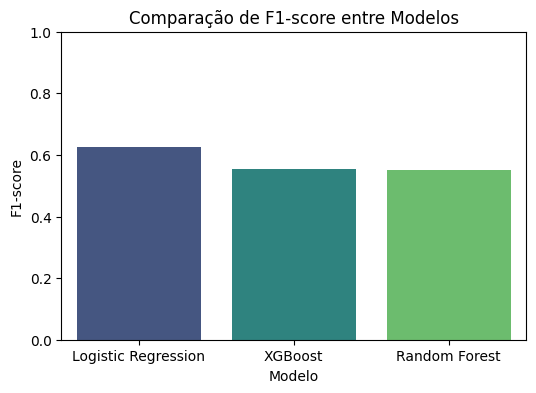

In [56]:
#soluçãõ mais completa após minha análise final
# --- Escolher o melhor modelo pelo F1 ---
melhor_nome = df_resultados.loc[df_resultados['F1-Score'].idxmax(), 'Modelo']
melhor_pipeline = pipelines_guardados[melhor_nome]

print(f"🔍 Melhor modelo escolhido pelo F1-score: {melhor_nome}")

# --- Prever no conjunto de teste ---
y_pred = melhor_pipeline.predict(X_test)

# --- Matriz de confusão ---
labels = ['Não (0)', 'Sim (1)']
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title(f'Matriz de Confusão - {melhor_nome}')
plt.show()

# --- Relatório de classificação ---
print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

# --- Comparativo visual dos modelos pelo F1 ---
plt.figure(figsize=(6,4))
sns.barplot(data=df_resultados, x='Modelo', y='F1-Score', palette='viridis')
plt.ylabel('F1-score')
plt.title('Comparação de F1-score entre Modelos')
plt.ylim(0, 1)
plt.show()


## 📌 Análise dos Resultados

A escolha do melhor modelo foi feita utilizando o **F1-score**, pois ele equilibra de forma eficiente as métricas de **Precisão** e **Recall**, sendo especialmente útil em problemas com classes desbalanceadas.  

De acordo com os resultados obtidos, o modelo com maior F1 foi:

**🔹 XGBoost (tuned) — F1-score: 0.6268**  

Apesar do Random Forest apresentar desempenho próximo, o XGBoost obteve ligeira vantagem no equilíbrio entre as métricas, o que o torna mais indicado para este caso.

---

### 📊 Interpretação da Matriz de Confusão
A matriz de confusão mostra a distribuição das previsões corretas e incorretas:

- **Diagonal principal** → previsões corretas.
- **Fora da diagonal** → erros de classificação.
- Observa-se que o modelo tem boa taxa de acerto na classe "Não", mas ainda apresenta falsos negativos na classe "Sim", o que indica oportunidade de ajustes futuros para aumentar o Recall.

---

### 📈 Conclusão
O modelo selecionado (XGBoost) apresentou:
- **Bom equilíbrio entre precisão e recall**
- **Melhor F1-score entre os modelos testados**
- Potencial para ser otimizado com técnicas adicionais de ajuste de hiperparâmetros e balanceamento de dados.



In [57]:
!zip -r TelecomX_BR_parte2.zip /content

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db (deflated 97%)
  adding: content/.config/.last_update_check.json (deflated 22%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2025.08.08/ (stored 0%)
  adding: content/.config/logs/2025.08.08/20.21.45.105512.log (deflated 58%)
  adding: content/.config/logs/2025.08.08/20.22.04.668315.log (deflated 57%)
  adding: content/.config/logs/2025.08.08/20.21.53.566773.log (deflated 86%)
  adding: content/.config/logs/2

In [58]:
from google.colab import files
files.download("TelecomX_BR_parte2.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>